## GPT Architechture
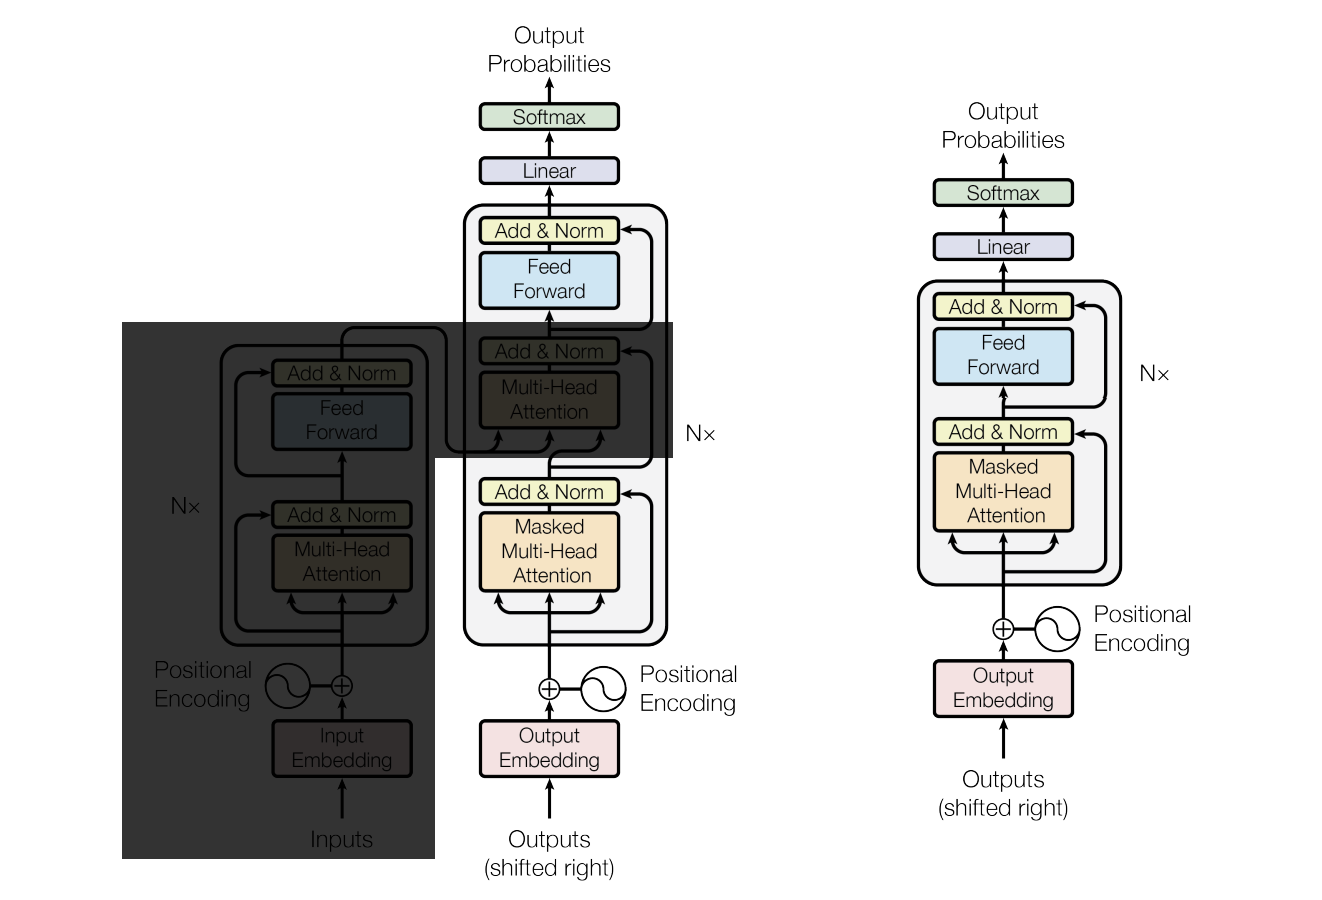

In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Callable, Optional, Tuple

texts = [
    "乂煞氣a思齊乂",
    "乂在關渡每過60秒就過了1分鐘。乂",
    "乂打火機比火柴更早被發明出來。乂",
    "乂張開眼睛打噴嚏，這是不可能的事。乂",
    "乂房子很貴不是它的缺點，是我的缺點。乂",
    "乂人睡覺比坐著看電視所消耗的卡路里還多。乂",
    "乂Q:豆腐拍照會變什麼?A:擺YA豆腐。乂",
    "乂Q:為什麼小鳥總是嘰嘰喳喳?A:因為小鳥E人。乂",
    "乂Q:為什麼吸血鬼不喜歡吃辣?A:因為他們喜歡blood。乂",
    "乂Q:為什麼游泳選手總是不小心?A:因為他們總是帽帽濕濕的。乂"
]
vocab = {k: v for k, v in enumerate([""] + list(set("".join(texts))))}

@dataclass
class ModelArgs:
    d_model: int = 768
    num_layers: int = 12
    num_heads: int = 12
    dropout: float = 0.1
    vocab_size: int = len(vocab)

    max_batch_size: int = 32
    max_seq_len: int = 32

In [2]:
class Tokenizer:
    def __init__(self, vocab: dict):
        self.token2text = vocab
        self.text2token = {v: k for k, v in vocab.items()}

    def encode(self, text: str):
        tokens = [self.text2token[c] for c in text]
        tokens = [0] * (ModelArgs.max_seq_len - len(tokens)) + tokens
        return torch.tensor(tokens)

    def decode(self, tokens: str):
        return "".join([self.token2text[int(t)] for t in tokens])

tokenizer = Tokenizer(vocab)
print(texts[0], "->", tokenizer.encode(texts[0]), "->", tokenizer.decode(tokenizer.encode(texts[0])))

datasets = []
for text in texts:
    for idx in range(len(text)):
        if idx < 3 or idx > len(text) - 1:
            continue
        train = text[:idx]
        label = text[:idx+1]
        datasets.append([tokenizer.encode(train), tokenizer.encode(label)])
print("inputs:", datasets[0][0].shape)
print(tokenizer.decode(datasets[0][0]))
print("target:", datasets[0][1].shape)
print(tokenizer.decode(datasets[0][1]))

class TextDataset(torch.utils.data.Dataset):
    def __init__(self):
        self.dataset = datasets

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]

train_dataloader = torch.utils.data.DataLoader(TextDataset(), batch_size=ModelArgs.max_batch_size, shuffle=True)

乂煞氣a思齊乂 -> tensor([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  91,  80,  72,
         74, 108,  77,  91]) -> 乂煞氣a思齊乂
inputs: torch.Size([32])
乂煞氣
target: torch.Size([32])
乂煞氣a


In [3]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()

class DecoderBlock(nn.Module):
    def __init__(self, args: ModelArgs, device: str):
        super(DecoderBlock, self).__init__()

class TransformerDecoder(nn.Module):
    def __init__(self, args: ModelArgs):
        super(TransformerDecoder, self).__init__()

        self.embedding = nn.Embedding(args.vocab_size, args.d_model)
        self.pos_encoder = PositionalEncoding(args.d_model, args.dropout, args.max_seq_len)
        self.transformer_block = nn.ModuleList()
        for layer_id in range(args.num_layers):
            device = f"cuda:{int(layer_id // (args.num_layers / torch.cuda.device_count()))}"
            self.transformer_block.append(DecoderBlock(args, device))
        self.linear = nn.Linear(args.d_model, args.vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

TransformerDecoder(ModelArgs)

TransformerDecoder(
  (embedding): Embedding(113, 768)
  (pos_encoder): PositionalEncoding()
  (transformer_block): ModuleList(
    (0-11): 12 x DecoderBlock()
  )
  (linear): Linear(in_features=768, out_features=113, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

In [4]:
# text Embedding
x = torch.randint(0, ModelArgs.vocab_size, (ModelArgs.max_batch_size, ModelArgs.max_seq_len))
print(x.shape)
x_emb = nn.Embedding(ModelArgs.vocab_size, ModelArgs.d_model)(x)
print(x_emb.shape)

torch.Size([32, 32])
torch.Size([32, 32, 768])


In [5]:
# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

x_pos = PositionalEncoding(d_model=ModelArgs.d_model, max_len=ModelArgs.max_seq_len)(x_emb)
print(x_pos.shape)

torch.Size([32, 32, 768])


In [6]:
# Decoder Block
class DecoderBlock(nn.Module):
    def __init__(self, args: ModelArgs, device: str):
        super(DecoderBlock, self).__init__()

        ff_hidden_layer = 4 * args.d_model
        self.self_attention = nn.MultiheadAttention(args.d_model, args.num_heads, dropout=args.dropout)
        self.norm1 = nn.LayerNorm(args.d_model)
        self.dropout1 = nn.Dropout(args.dropout)
        self.linear1 = nn.Linear(args.d_model, ff_hidden_layer)
        self.linear2 = nn.Linear(ff_hidden_layer, args.d_model)
        self.norm2 = nn.LayerNorm(args.d_model)
        self.dropout2 = nn.Dropout(args.dropout)
        
        self.device = device
        self = self.to(device)

    
    def forward(self, x, target_mask):
        x = x.to(self.device)
        target_mask = target_mask if target_mask is None else target_mask.to(self.device)
        
        attn_output, _ = self.self_attention(x, x, x, attn_mask=target_mask)
        x = x + self.dropout1(attn_output)
        x = self.norm1(x)
        ff_output = self.linear2(F.relu(self.linear1(x)))
        x = x + self.dropout2(ff_output)
        x = self.norm2(x)
        x = x.to("cpu")
        return x


x_doc = DecoderBlock(ModelArgs, "cpu")(x_pos, None)
print(x_doc.shape)

torch.Size([32, 32, 768])


In [7]:
def generate_square_subsequent_mask(sz):
    """Generate a mask to prevent attention to future positions."""
    mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask

# Transformer Decoder
class TransformerDecoder(nn.Module):
    def __init__(self, args: ModelArgs):
        super(TransformerDecoder, self).__init__()

        self.embedding = nn.Embedding(args.vocab_size, args.d_model)
        self.pos_encoder = PositionalEncoding(args.d_model, args.dropout, args.max_seq_len)
        self.transformer_blocks = nn.ModuleList()
        for layer_id in range(args.num_layers):
            device = f"cuda:{int(layer_id // (args.num_layers / torch.cuda.device_count()))}"
            self.transformer_blocks.append(DecoderBlock(args, device))
        self.linear = nn.Linear(args.d_model, args.vocab_size)
        self.softmax = nn.LogSoftmax(dim=-1)

    
    def forward(self, x):
        x = self.embedding(x)
        x = self.pos_encoder(x)
        tgt_mask = generate_square_subsequent_mask(x.size(0))
        for transformer_block in self.transformer_blocks:
            target_mask = generate_square_subsequent_mask(x.size(0))
            x = transformer_block(x,target_mask)
        output = self.linear(x)
        output = self.softmax(output)
        return output

model = TransformerDecoder(ModelArgs)
model

TransformerDecoder(
  (embedding): Embedding(113, 768)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_blocks): ModuleList(
    (0-11): 12 x DecoderBlock(
      (self_attention): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
      )
      (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (linear1): Linear(in_features=768, out_features=3072, bias=True)
      (linear2): Linear(in_features=3072, out_features=768, bias=True)
      (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
  (linear): Linear(in_features=768, out_features=113, bias=True)
  (softmax): LogSoftmax(dim=-1)
)

In [8]:
optim = torch.optim.AdamW(model.parameters(), lr=1e-5)
epochs = 1000
for epoch in range(epochs):
    train_loss = 0
    for i, data in enumerate(train_dataloader):
        optim.zero_grad()
        model.train(True)
        inputs, target = data
        output = model(inputs)
        logits = output.view(-1, ModelArgs.vocab_size)
        target = target.view(-1).to(logits.device)
        loss = F.cross_entropy(logits, target)
        loss.backward()
        optim.step()
        train_loss = train_loss + loss.data
        model.eval()
    train_loss = train_loss / len(train_dataloader)
    if epoch < 10 or (epoch + 1) % 100 < 1:
        print("Epoch {: 5d}/{}\t- loss: {:.4f}".format(epoch + 1, epochs, train_loss))

Epoch     1/1000	- loss: 3.1041
Epoch     2/1000	- loss: 2.2551
Epoch     3/1000	- loss: 2.0207
Epoch     4/1000	- loss: 1.8118
Epoch     5/1000	- loss: 1.6799
Epoch     6/1000	- loss: 1.5473
Epoch     7/1000	- loss: 1.4369
Epoch     8/1000	- loss: 1.3254
Epoch     9/1000	- loss: 1.2130
Epoch    10/1000	- loss: 1.1489
Epoch   100/1000	- loss: 0.2863
Epoch   200/1000	- loss: 0.2801
Epoch   300/1000	- loss: 0.2791
Epoch   400/1000	- loss: 0.2752
Epoch   500/1000	- loss: 0.2741
Epoch   600/1000	- loss: 0.2721
Epoch   700/1000	- loss: 0.2745
Epoch   800/1000	- loss: 0.2747
Epoch   900/1000	- loss: 0.2746
Epoch  1000/1000	- loss: 0.2703


In [9]:
prompts = [
    "乂煞氣",
    "乂在關渡",
    "乂打火機比",
    "乂張開眼睛打",
    "乂房子很貴不是",
    "乂人睡覺比坐著看",
    "乂Q:豆腐拍照會變什",
    "乂Q:為什麼小鳥總是嘰",
    "乂Q:為什麼吸血鬼不喜歡",
    "乂Q:為什麼游泳選手總是不"
]
model.eval()
for prompt in prompts:
    while prompt[-1] != "乂":
        if len(prompt) > ModelArgs.max_seq_len - 2:
            break
        tokens = tokenizer.encode(prompt)
        tokens = tokens[None, :]
        output = model(tokens)
        nexttk = [int(torch.argmax(output[:, -1], dim=-1))]
        nextwd = tokenizer.decode(nexttk)
        prompt = prompt + nextwd
    print(prompt)

乂煞氣a思齊乂
乂在關渡每過60秒就過60秒就過60秒就過60秒就過60秒就過
乂打火機比坐著看電視所消耗的缺點，這是不喜歡吃辣?A:為什麼吸
乂張開眼睛打噴嚏，這是不喜歡吃辣?A:為什麼吸血鬼不喜歡吃辣?
乂房子很貴不是不喜歡吃辣?A:為什麼吸血鬼不喜歡吃辣?A:為什
乂人睡覺比坐著看電視所消耗的缺點，這是不喜歡吃辣?A:為什麼吸
乂Q:豆腐拍照會變什麼吸血鬼不喜歡吃辣?A:為什麼吸血鬼不喜歡
乂Q:為什麼小鳥總是嘰喳喳喳喳喳喳喳喳喳喳喳喳喳喳喳喳喳喳喳喳
乂Q:為什麼吸血鬼不喜歡吃辣?A:為什麼吸血鬼不喜歡吃辣?A:
乂Q:為什麼游泳選手總是不喜歡吃辣?A:為什麼吸血鬼不喜歡吃辣


## Reference

[Building Custom GPT with PyTorch](https://medium.com/@akriti.upadhyay/building-custom-gpt-with-pytorch-59e5ba8102d4)